In [1]:
import numpy as np
from control import *
import pandas as pd
import math
import matplotlib.pyplot as plt
from simulation_tools import Servo
from scipy.integrate import odeint

In [2]:
def deg2rad(deg):
    return deg * math.pi / 180

In [3]:
rot_servo = Servo("rotation", 0.32, 0.06, 0.00879)

In [4]:
u_limit = 130

In [5]:
def run_simulation(T, y0, u):
    dy = np.zeros(len(T))
    y = np.zeros(len(T))

    dy[0] = y0[0]
    y[0] = y0[1]
    for i in range(1, len(T)):
        y_ticks = (y[i-1] + math.pi) * 180 / math.pi * 11.3611111111111111111111
        if u[i] - y_ticks > u_limit:
            u_sat = y_ticks + u_limit
        elif u[i] - y_ticks < -u_limit:
            u_sat = y_ticks - u_limit
        else:
            u_sat = u[i]
            
        u_sat = u_sat/ 11.3611111111111111111111 * math.pi / 180 - math.pi #Ticks to degree to radians
        _, state = odeint(rot_servo.ode, [dy[i-1], y[i-1]], [T[i-1], T[i]], args=(u_sat,))
        dy[i] = state[0]
        y[i] = state[1]
    return y

# Comparing simulation to actual

In [6]:
def compare_sim_actual(file, th, servo_type):
    log = pd.read_csv(file, sep=",")
    grouped = log.groupby(['freq'])

    w_actual= []
    mag_actual = []
    for freq in grouped:
        df = freq[1]
        w_actual.append(freq[0]*2*math.pi)

        gain = (df['pos'].max() - df['pos'].min())/(df['sig'].max() - df['sig'].min())
        mag_actual.append(20*np.log(gain))

    T = np.arange(0, 5, 0.005)

    for freq in grouped:
        df = freq[1]

        u = np.array(df['sig'])
        y = run_simulation(T, [0, 0], u)
        
        y_ticks = (y + math.pi) * 180 / math.pi * 11.3611111111111111111111
        plt.plot(T, df['sig'])
        plt.plot(T, y_ticks)
        plt.plot(T, df['pos'])
        plt.legend(['command', 'simulation', 'actual'])
        plt.xlabel('Time (s)')
        plt.ylabel('Servo position (counts)')
        plt.title("Square wave input at {0:.3f} rad/sec: {1}".format(freq[0] * 2 * math.pi, servo_type))
        plt.show()


# Peak-to-peak 1000 counts

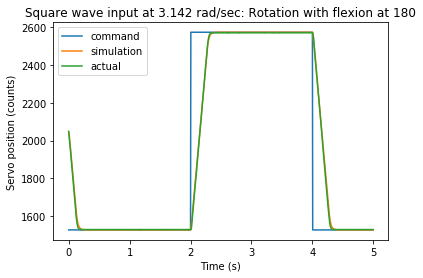

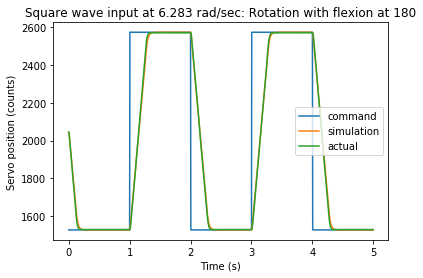

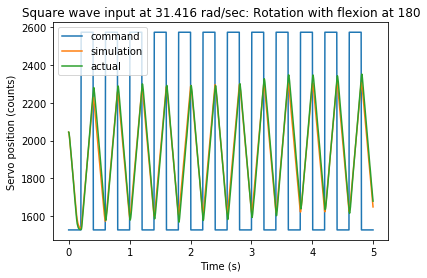

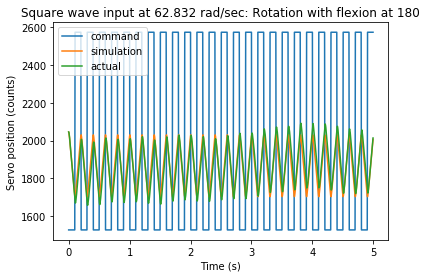

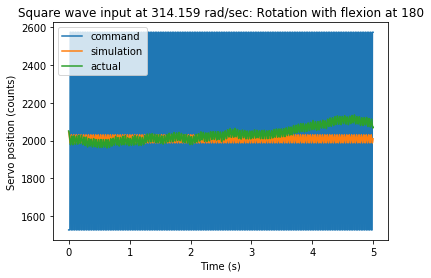

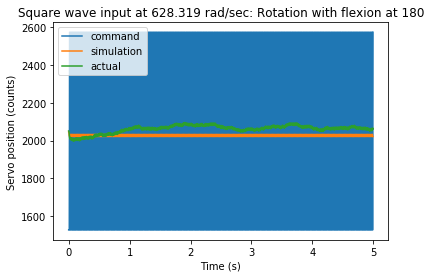

In [7]:
#Rotation
compare_sim_actual("logs_large_a/rot_log.txt", 180, "Rotation with flexion at 180")

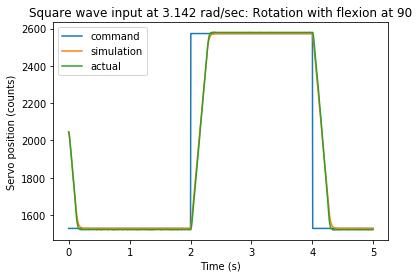

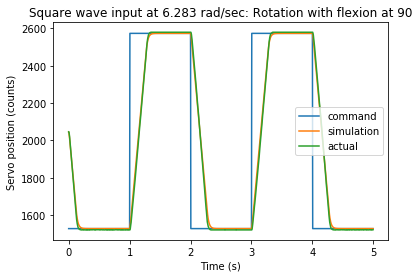

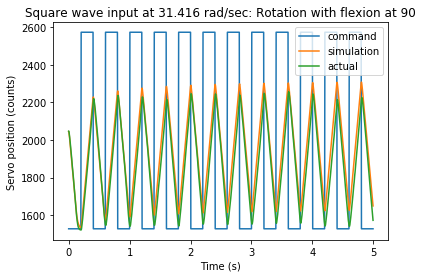

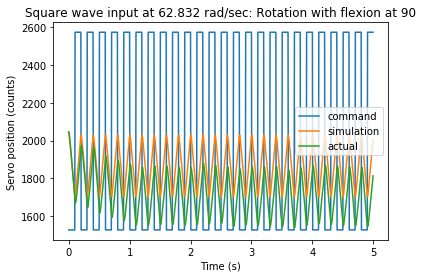

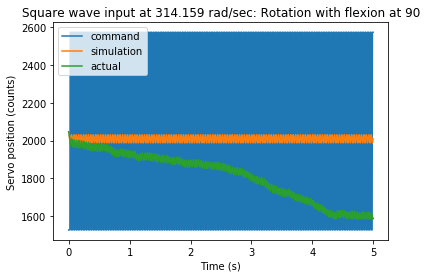

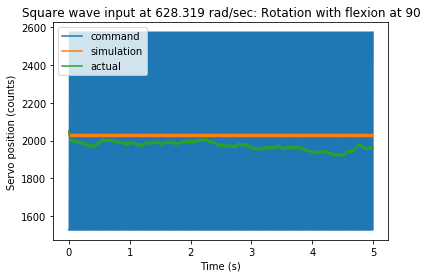

In [8]:
#Rotation with flexion up
compare_sim_actual("logs_large_a/rot_flex_up_log.txt", 90, "Rotation with flexion at 90")

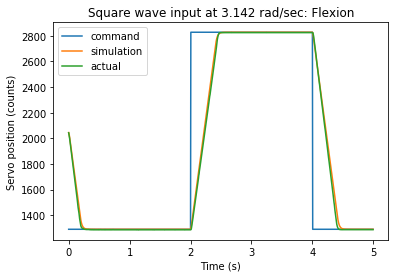

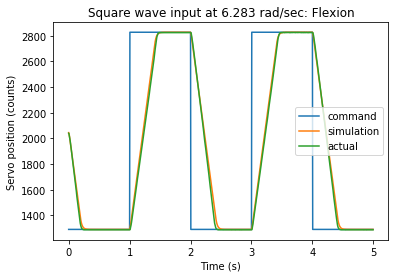

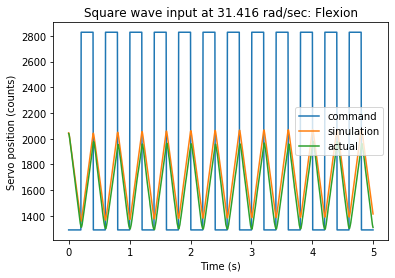

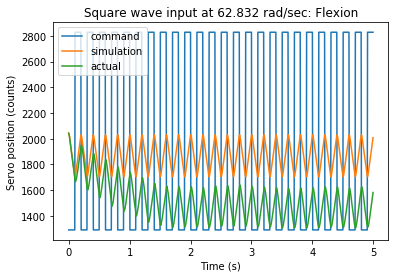

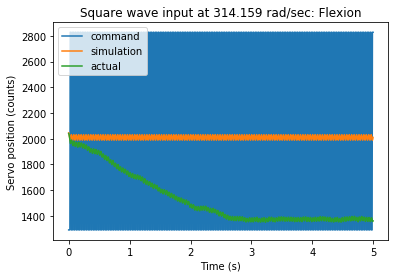

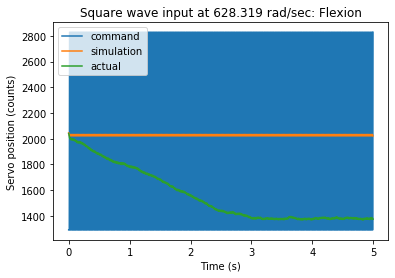

In [9]:
#Flexion (affected by gravity)
compare_sim_actual("logs_large_a/flex_log.txt", None, "Flexion")

# Lowering peak-to-peak amplitude to 200 to avoid saturation

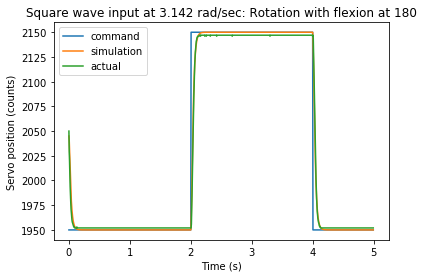

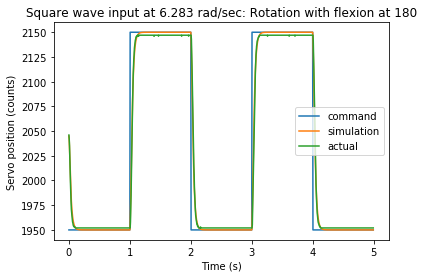

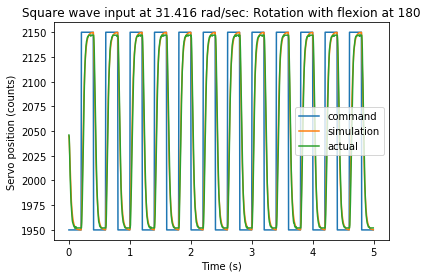

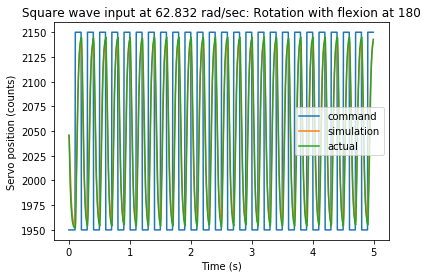

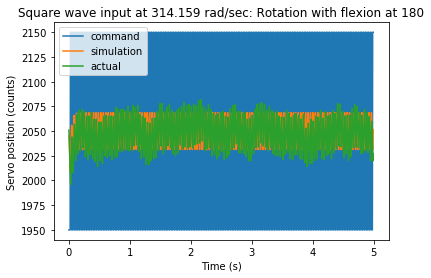

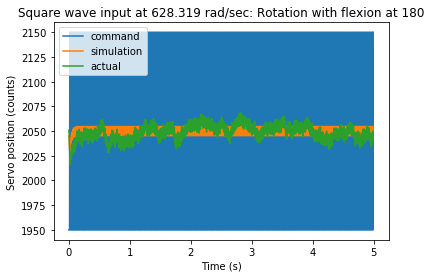

In [64]:
compare_sim_actual("logs_200_a/rot_log.txt", 180, "Rotation with flexion at 180")

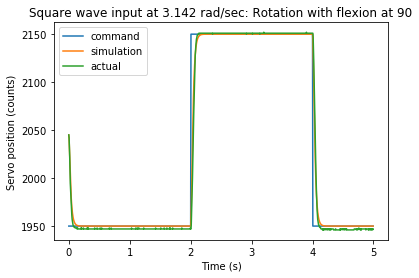

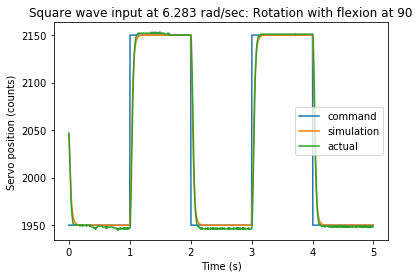

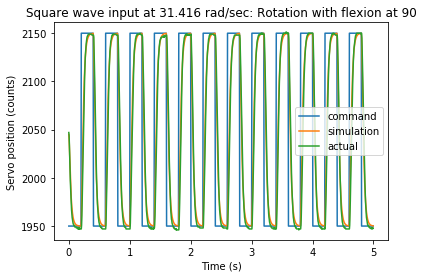

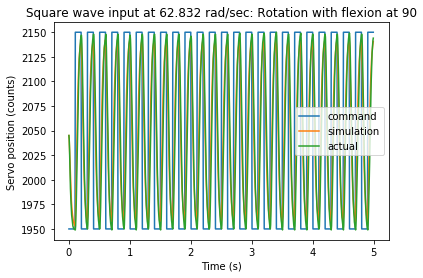

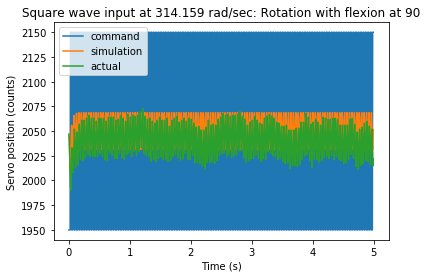

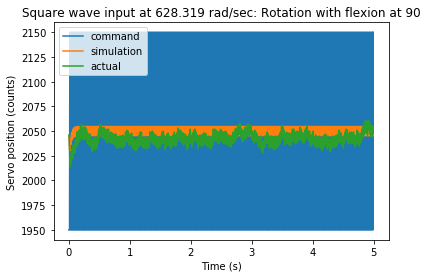

In [65]:
compare_sim_actual("logs_200_a/rot_flex_up_log.txt", 90, "Rotation with flexion at 90")

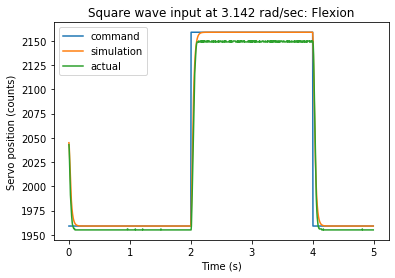

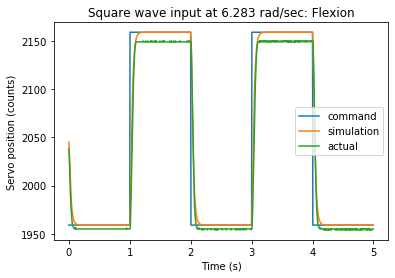

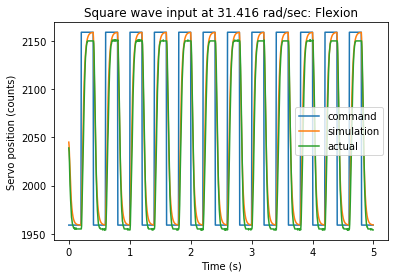

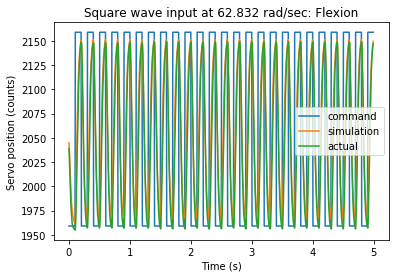

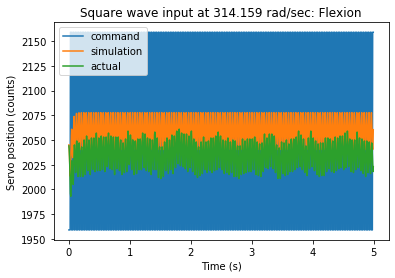

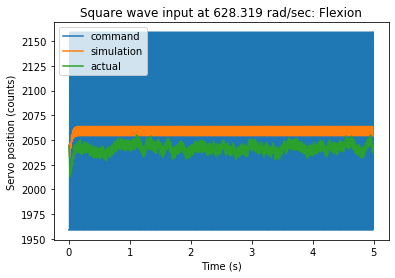

In [66]:
compare_sim_actual("logs_200_a/flex_log.txt", None, "Flexion")